<a href="https://colab.research.google.com/github/armiro/Pneumothorax-Segmentation/blob/master/pnx_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**session-holder via page element inspection**

click on the `refresh` button every 60 seconds.

`Ctrl + shift + I` to open inspection, insert the code in the console
```
function ClickRefresh(){
    console.log("Clicked on refresh button"); 
    document.querySelector("paper-icon-button").click()
}
setInterval(ClickRefresh, 60000)
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glob, cv2, gzip, gc, time

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, concatenate, Lambda
from tensorflow.keras import Model, backend as K, callbacks as cb, optimizers

In [ ]:
# load the dataset
path = '/content/drive/MyDrive/Datasets/siim_acr_pneumothorax_seg/'
img_file = gzip.GzipFile(filename=path+'training_images.npy.gz', mode='r')
%time images = np.load(file=img_file)
msk_file = gzip.GzipFile(filename=path+'training_masks_resized.npy.gz', mode='r')
%time masks = np.load(file=msk_file)
metadata = pd.read_csv(filepath_or_buffer=path+'converted-train-rle.csv', index_col=None)
age = metadata.loc[:, 'PatientAge']
sex = metadata.loc[:, 'PatientSex']
view = metadata.loc[:, 'ImageView']

print('metadata columns:', metadata.columns)
print('shape of the dataset:', images.shape)
print('shape of the masks:', masks.shape)

CPU times: user 28.4 s, sys: 1.38 s, total: 29.8 s
Wall time: 32.8 s
CPU times: user 8.2 s, sys: 623 ms, total: 8.82 s
Wall time: 46.6 s
metadata columns: Index(['ImageId', 'PatientId', 'PatientAge', 'PatientSex', 'ImageView'], dtype='object')
shape of the dataset: (12047, 512, 512)
shape of the masks: (12047, 512, 512)


In [ ]:
# because of memory limit, manual data splitter is defined so that we can split 
# images and masks in different steps and delete unnecessary variables in between
def manual_train_test_split(data, test_ratio, init_indices):
    if init_indices is not None:
        shuffle_indices = init_indices
    else:
        shuffle_indices = np.random.RandomState(seed=23).permutation(len(data))
    test_size = int(test_ratio * len(data))
    test_indices = shuffle_indices[:test_size]
    train_indices = shuffle_indices[test_size:]
    return data[train_indices], data[test_indices], shuffle_indices


images = np.expand_dims(images, axis=-1)
X_train, X_val, indices = manual_train_test_split(data=images, test_ratio=0.2, init_indices=None)
del images
gc.collect()

masks = np.expand_dims(masks, axis=-1)
y_train, y_val, _ = manual_train_test_split(data=masks, test_ratio=0.2, init_indices=indices)
del masks
gc.collect()

In [ ]:
# define metrics: dice coefficient (DICE/F1-score) and intersection over union (IoU/Jaccard)
def dice_coef(y_true, y_pred, smooth=1):
    overlap = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    total_area = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dsc = K.mean((2.0 * overlap + smooth) / (total_area + smooth), axis=0)
    return dsc


def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [ ]:
# define custom loss as a combination of dice and bce
def dice_loss():
    pass



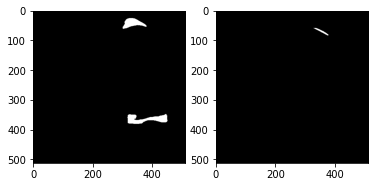

inter-dice is: tf.Tensor(0.00023685457129322596, shape=(), dtype=float64) and inter-jaccard is: tf.Tensor(0.00023685457129322596, shape=(), dtype=float64)
self-dice is: tf.Tensor(1.0, shape=(), dtype=float64) and self-jaccard is: tf.Tensor(1.0, shape=(), dtype=float64)


In [ ]:
# test masks to see if both DSC ans IoU metrics are working correctly
im1 = np.expand_dims(y_train[22], axis=0).astype('float64')
im2 = np.expand_dims(y_train[12], axis=0).astype('float64')

plt.subplot(1, 2, 1)
plt.imshow(X=np.squeeze(im1, axis=(0, -1)), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(X=np.squeeze(im2, axis=(0, -1)), cmap='gray')
plt.show()

print('inter-dice is:', dice_coef(im1, im2), 'and inter-jaccard is:', iou_coef(im1, im2))
print('self-dice is:', dice_coef(im1, im1), 'and self-jaccard is:', iou_coef(im1, im1))

In [ ]:
# model architecture: vanilla unet
def vanilla_unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    ds_inputs = Lambda(lambda image: image/255.0, name='down_scaler')(inputs)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(ds_inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # pool1 = Dropout(rate=0.1)(pool1)
    
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # pool2 = Dropout(rate=0.1)(pool2)
 
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # pool3 = Dropout(rate=0.1)(pool3)
 
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    # pool4 = Dropout(rate=0.1)(pool4)
 
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    # conv5 = Dropout(rate=0.1)(conv5)
 
    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    # conv6 = Dropout(rate=0.1)(conv6)
 
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    # conv7 = Dropout(rate=0.1)(conv7)
 
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)
    # conv8 = Dropout(rate=0.1)(conv8)
 
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    # conv9 = Dropout(rate=0.1)(conv9)
 
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
    return Model(inputs=[inputs], outputs=[conv10], name='segmentor')
 

model = vanilla_unet(input_size=(512, 512, 1))
# customAdam = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, iou_coef])
model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# model architecture: efficientnet-unet




In [ ]:
# define image augmentation function using keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

img_aug = ImageDataGenerator(rotation_range=30, horizontal_flip=True, vertical_flip=False, 
                             zoom_range=[0.9, 1.1], brightness_range=[0.9, 1.1], rescale=None,
                             width_shift_range=0.1, height_shift_range=0.1, fill_mode='constant', 
                             zca_whitening=False, dtype='uint8')

In [ ]:
# OOP-based batch loader with shuffling option
class BatchLoader():
    def __init__(self, x_train, y_train, batch_size):
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.indices = np.arange(len(x_train))
        self.counter = 0
    
    def get_next(self):
        x_batch = list()
        y_batch = list()
        # select indexed samples from images and masks
        start = self.counter * self.batch_size
        for i in range(self.batch_size):
            x_batch.append(self.x_train[self.indices[start+i]])
            y_batch.append(self.y_train[self.indices[start+i]])
        self.counter += 1
        # apply image augmentation on both images and masks
        rnd_seed = np.random.randint(400)
        gen_img = img_aug.flow(np.array(x_batch), batch_size=self.batch_size, shuffle=False, seed=rnd_seed)
        gen_msk = img_aug.flow(np.array(y_batch), batch_size=self.batch_size, shuffle=False, seed=rnd_seed)
        x_batch.clear()
        y_batch.clear()
        x_batch = gen_img.next().astype('uint8')
        y_batch = gen_msk.next()
        y_batch = [np.where(mask > 0, 1.0, 0.0) for mask in y_batch] # disable brightness adj. effect on masks
        return np.array(x_batch), np.array(y_batch)
    
    def shuffle(self):
        np.random.shuffle(self.indices)
        print('shuffled batch indices')

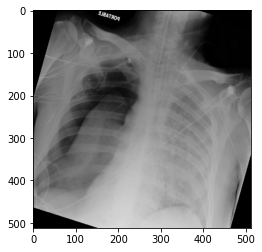

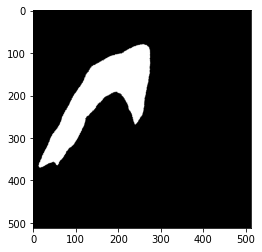

237 1.0
<class 'numpy.uint8'>


In [ ]:
# test to see if data augmentation is working correctly for the masks
btl = BatchLoader(X_train, y_train, batch_size=1)
# btl.shuffle()
xt, yt = btl.get_next()
plt.imshow(np.squeeze(xt, axis=(0, -1)), cmap='gray')
plt.show()
plt.imshow(np.squeeze(yt, axis=(0, -1)), cmap='gray')
plt.show()
print(np.max(xt), np.max(yt))
print(type(xt[0][0][0][0]))

In [ ]:
# define training callbacks
# checkpoint = cb.ModelCheckpoint('/content/drive/My Drive/pnx_model/eps={epoch:03d}_loss={loss:.4f}.hdf5',
#                                 monitor='loss', verbose=2, save_best_only=True, mode='auto')
# cb_list = [checkpoint]


# model.load_weights('/content/drive/MyDrive/pnx_model/eps=xxx_valLoss=0.xxxx.hdf5')

In [ ]:
num_epochs = 60
current_epoch = 1
step_epoch = len(X_train) // 32.0
num_iter = 0
losses = list()
batch_loader = BatchLoader(x_train=X_train, y_train=y_train, batch_size=32)

while current_epoch < num_epochs:
    t0 = time.time()
    while num_iter < step_epoch:
        xb, yb = batch_loader.get_next()
        losses.append(model.train_on_batch(xb, yb))
        num_iter += 1
    batch_loader.shuffle()
    batch_loader.counter = 0
    print('epoch:', current_epoch, '| elapsed time:', round((time.time()-t0)/60.0, 2), 'mins')
    model.evaluate(x=X_train, y=y_train, verbose=1)
    current_epoch += 1
    num_iter = 0
print('training finished!')

print('final model eval on training set:')
model.evaluate(x=X_train, y=y_train, verbose=1)
print('final model eval on validation set:')
model.evaluate(x=X_val, y=y_val, verbose=1)

In [ ]:
model.save('/content/drive/MyDrive/pnx_model/unet_with_aug.hdf5')

Epoch 1/100
301/301 - 121s - loss: 0.0405 - dice_coef: 0.0029 - iou_coef: 0.0020 - val_loss: 0.0194 - val_dice_coef: 0.0029 - val_iou_coef: 0.0020
Epoch 2/100
301/301 - 120s - loss: 0.0196 - dice_coef: 0.0032 - iou_coef: 0.0022 - val_loss: 0.0194 - val_dice_coef: 0.0032 - val_iou_coef: 0.0023
Epoch 3/100
301/301 - 119s - loss: 0.0190 - dice_coef: 0.0040 - iou_coef: 0.0026 - val_loss: 0.0191 - val_dice_coef: 0.0056 - val_iou_coef: 0.0031
Epoch 4/100
301/301 - 119s - loss: 0.0186 - dice_coef: 0.0050 - iou_coef: 0.0032 - val_loss: 0.0178 - val_dice_coef: 0.0066 - val_iou_coef: 0.0041
Epoch 5/100
301/301 - 119s - loss: 0.0177 - dice_coef: 0.0078 - iou_coef: 0.0046 - val_loss: 0.0167 - val_dice_coef: 0.0108 - val_iou_coef: 0.0060
Epoch 6/100
301/301 - 119s - loss: 0.0169 - dice_coef: 0.0101 - iou_coef: 0.0058 - val_loss: 0.0163 - val_dice_coef: 0.0102 - val_iou_coef: 0.0058
Epoch 7/100
301/301 - 119s - loss: 0.0162 - dice_coef: 0.0117 - iou_coef: 0.0067 - val_loss: 0.0164 - val_dice_coef: 0

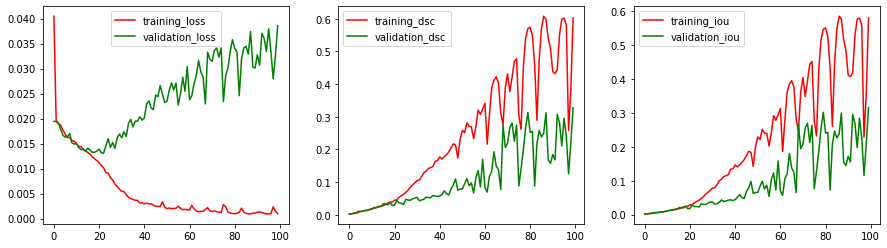

In [ ]:
training = model.fit(x=X_train, y=y_train, batch_size=32, epochs=100, verbose=2,
                     steps_per_epoch=len(X_train)//32.0, validation_data=(X_val, y_val),
                     max_queue_size=20, workers=4, use_multiprocessing=True)

fig = plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(training.history['loss'], color='r', label='training_loss')
plt.plot(training.history['val_loss'], color='g', label='validation_loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(training.history['dice_coef'], color='r', label='training_dsc')
plt.plot(training.history['val_dice_coef'], color='g', label='validation_dsc')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(training.history['iou_coef'], color='r', label='training_iou')
plt.plot(training.history['val_iou_coef'], color='g', label='validation_iou')
plt.legend()
plt.show()
fig.savefig('/content/drive/My Drive/pnx_model/training.png', bbox_inches='tight')

In [ ]:
# model.save('/content/drive/MyDrive/pnx_model/unet_eps=100_dsc=0.60_valdsc=0.33.hdf5')
# model.load_weights('/content/drive/MyDrive/pnx_model/01_eps=022_valLoss=0.0114.hdf5')

3720


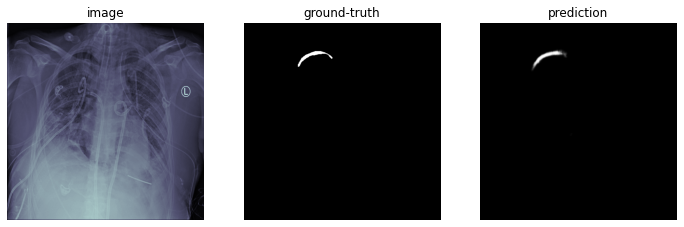

In [ ]:
idx = np.random.randint(0, len(X_train))
# idx = 6994
print(idx)
fig = plt.figure(num=3, figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('image')
plt.imshow(X=X_train[idx].squeeze(), cmap='bone')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('ground-truth')
plt.imshow(X=y_train[idx].squeeze(), cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('prediction')
pred = model.predict(np.expand_dims(X_train[idx], axis=0))
# pred = np.where(pred>0.000005, 1, 0)
plt.imshow(X=np.squeeze(pred, axis=(0, -1)), cmap='gray')
plt.axis('off')
plt.show()
# fig.savefig('/content/drive/MyDrive/unet_v1_XX.png', bbox_inches='tight')